In [17]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [18]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [19]:
y.shape

(70000,)

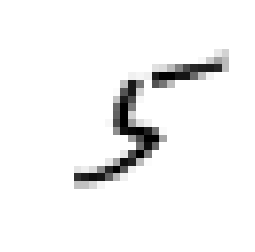

In [20]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[35000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.show()

In [89]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [82]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train , y_train = X_train[shuffle_index], y_train[shuffle_index]

In [22]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5 )

In [23]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [24]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

## Implementing cross-validation

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    

0.86285
0.83465
0.82195


In [26]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9554 ,  0.93935,  0.9545 ])

In [27]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [28]:
never5_clf = Never5Classifier()
cross_val_score(never5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9119 ,  0.9079 ,  0.90915])

In [29]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54414,   165],
       [ 2850,  2571]])

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train_5, y_train_pred)

0.9396929824561403

In [32]:
recall_score(y_train_5, y_train_pred)

0.4742667404537908

In [33]:
f1_score(y_train_5, y_train_pred)

0.63037881574108123

In [34]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 95497.16692708])

In [35]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [36]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [37]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

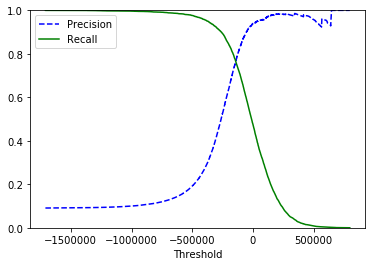

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

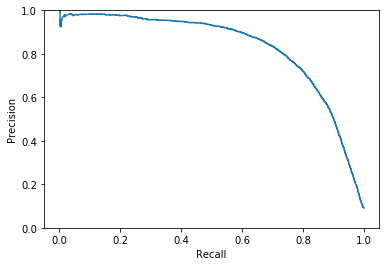

In [39]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0, 1])
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [40]:
y_train_pred_90 = (y_scores > -30000)
print("precision score: ", precision_score(y_train_5, y_train_pred_90))
print("recall score: ", recall_score(y_train_5, y_train_pred_90))

precision score:  0.92246835443
recall score:  0.53772366722


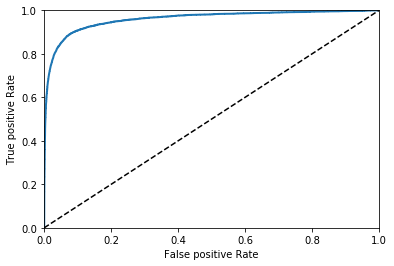

In [41]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False positive Rate")
    plt.ylabel("True positive Rate")
    
plot_roc_curve(fpr, tpr)
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.95981268758845073

In [43]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest   = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                     method="predict_proba")

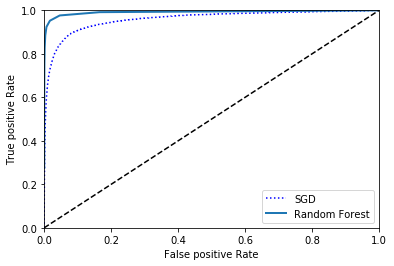

In [44]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

0.99198071830600676

In [46]:
print(precision_score(y_train_5, y_scores_forest>0.5))
print(recall_score(y_train_5, y_scores_forest>0.5))

0.983541803818
0.826784726065


## Multiclass

In [47]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([ 5.])

In [48]:
some_digit_scores  =sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-246419.33498768,  -16616.34296517,  -48363.49800761,
        -289187.48033256, -116499.05677942,   95497.16692708,
        -367913.71267316, -187247.07914339,  -45722.62981407,
        -395999.4457505 ]])

In [49]:
np.argmax(some_digit_scores)

5

In [50]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [51]:
sgd_clf.classes_[5]

5.0

In [52]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [53]:
len(ovo_clf.estimators_)

45

In [54]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [55]:
forest_clf.predict_proba([some_digit])

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [56]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.87417516,  0.84909245,  0.86102915])

In [62]:
from sklearn.preprocessing import StandardScaler
#scaler=StandardScaler(copy=False)
# initialize on part of the set because of memory issues, it should still help
scaler.fit(X_train[:10000].astype(np.float64) )
X_train_scaled = scaler.transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90891822,  0.90719536,  0.91143672])

In [63]:
y_train_pred  =cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)


In [65]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5732,    3,   24,    9,   11,   45,   49,    8,   40,    2],
       [   1, 6495,   46,   24,    6,   38,    7,    9,  105,   11],
       [  55,   40, 5324,   95,   80,   29,   86,   62,  172,   15],
       [  53,   43,  151, 5301,    3,  253,   35,   56,  138,   98],
       [  19,   28,   41,    8, 5352,   11,   50,   35,   84,  214],
       [  74,   45,   45,  174,   76, 4590,  112,   22,  193,   90],
       [  34,   26,   50,    1,   38,   80, 5635,    7,   47,    0],
       [  26,   25,   72,   27,   55,   12,    5, 5814,   15,  214],
       [  58,  155,   79,  138,   11,  154,   60,   29, 5028,  139],
       [  46,   34,   32,   87,  160,   32,    3,  197,   78, 5280]])

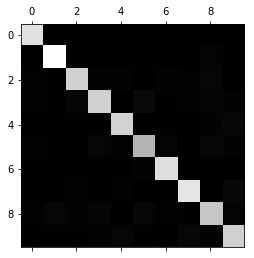

In [66]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

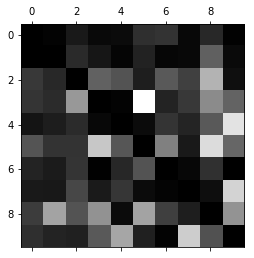

In [68]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [71]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

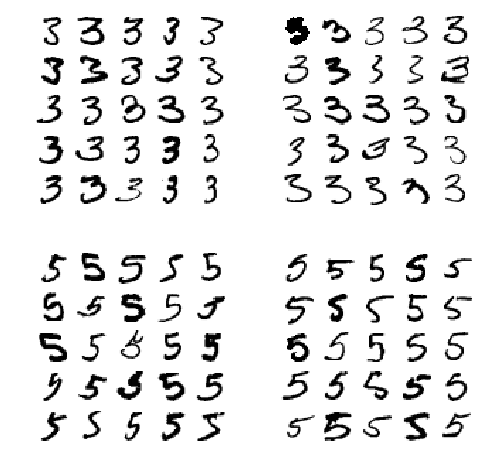

In [72]:
cl_a, cl_b = 3, 5
X_aa  =X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab  =X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba  =X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb  =X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [74]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd  = (y_train %  2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [75]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [78]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train[:10000], y_train[:10000], cv=3)
f1_score(y_train[:10000], y_train_knn_pred, average="macro")

0.93843255390237013

In [79]:
y_train_knn_pred.shape

(10000,)

In [84]:
noise=np.random.randint(0, 100, (len(X_train[:10000]), 784))
X_train_mod = X_train[:10000] + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train[:10000]
y_test_mod = X_test

In [88]:
knn_clf.fit(X_train_mod, y_train_mod)

C:\Users\Patrick\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


NameError: name 'plot_digit' is not defined

C:\Users\Patrick\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


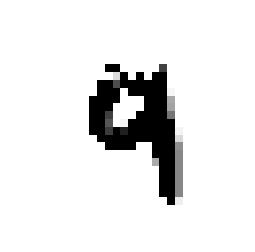

In [90]:
some_index=5000
clean_digit = knn_clf.predict(X_test_mod[some_index])
plot_digit(clean_digit)

In [87]:
X_test.shape

(10000, 784)

# Exercises

## 1

In [96]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = KNeighborsClassifier()
#knn_clf.fit(X_train, y_train)

In [92]:
cross_val_score(knn_clf, X_train[:10000], y_train[:10000], cv=3, scoring="accuracy")

array([ 0.94182909,  0.93131374,  0.93755629])

In [ ]:
param_grid = [
    {'n_neighbors' : [3,5,10], 'weights' : ['uniform', 'distance']}
]
knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf, param_grid, cv=3,
                          scoring='accuracy')

grid_search.fit(X_train[:20000], y_train[:20000])

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)